In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import camera_calibration_show_extrinsics as show
from PIL import Image

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
# (8,6) is for the given testing images.
# If you use the another data (e.g. pictures you take by your smartphone), 
# you need to set the corresponding numbers.
corner_x = 5
corner_y = 7
objp = np.zeros((corner_x*corner_y,3), np.float32)
objp[:,:2] = np.mgrid[0:corner_x, 0:corner_y].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('data_self/*.jpg')

# Step through the list and search for chessboard corners
print('Start finding chessboard corners...')
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray)

    #Find the chessboard corners
    print('find the chessboard corners of',fname)
    ret, corners = cv2.findChessboardCorners(gray, (corner_x,corner_y), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (corner_x,corner_y), corners, ret)
        plt.imshow(img)


#######################################################################################################
#                                Homework 1 Camera Calibration                                        #
#               You need to implement camera calibration(02-camera p.76-80) here.                     #
#   DO NOT use the function directly, you need to write your own calibration function from scratch.   #
#                                          H I N T                                                    #
#                        1.Use the points in each images to find Hi                                   #
#                        2.Use Hi to find out the intrinsic matrix K                                  #
#                        3.Find out the extrensics matrix of each images.                             #
#######################################################################################################


Start finding chessboard corners...
find the chessboard corners of data_self/55478060_353899928560145_8918517160855207936_n.jpg
find the chessboard corners of data_self/55604935_317458488916097_5724632531538542592_n.jpg
find the chessboard corners of data_self/54521990_577284632773223_2061408620737724416_n.jpg
find the chessboard corners of data_self/55451618_421290898631238_1427849460804747264_n.jpg
find the chessboard corners of data_self/54728392_396377241157771_7722729395848216576_n.jpg
find the chessboard corners of data_self/55719302_269619123960469_5614146490713767936_n.jpg
find the chessboard corners of data_self/55526845_333120757552992_1209445559144808448_n.jpg
find the chessboard corners of data_self/54517022_406333986811563_6106276560887611392_n.jpg
find the chessboard corners of data_self/54458037_425385201562362_8707778822335889408_n.jpg
find the chessboard corners of data_self/54519958_352166575391996_6533961806426144768_n.jpg


In [3]:
def callibrateCamera(objpoints, imgpoints):
    H_list = []
    for objp, imgp in zip(objpoints,imgpoints):
        # Homography
        A = np.zeros((5*7*2, 9))
        for i in range(5*7):
            A[i*2,:] = [objp[i,0], objp[i,1], 1, 0, 0, 0, -objp[i,0]*imgp[i,0,0], -objp[i,1]*imgp[i,0,0], -imgp[i,0,0]]
            A[i*2+1,:] = [0, 0, 0, objp[i,0], objp[i,1], 1, -objp[i,0]*imgp[i,0,1], -objp[i,1]*imgp[i,0,1], -imgp[i,0,1]]
        [U,S,V]=np.linalg.svd(A)
        m = V[np.argmin(S)]
        m *= 1/m[-1]
        #print("This value should be close to zero: "+str(np.sum(np.dot(A,m))))
        H = m.reshape((3,3))
        H_list.append(H)
    # intrinsic matrix
    def get_intrinsic_parameters(H_r):
        M = len(H_r)
        V = np.zeros((2*M, 6), np.float64)

        def v_pq(p, q, H):
            v = np.array([
                    H[0, p]*H[0, q],
                    H[0, p]*H[1, q] + H[1, p]*H[0, q],
                    H[1, p]*H[1, q],
                    H[2, p]*H[0, q] + H[0, p]*H[2, q],
                    H[2, p]*H[1, q] + H[1, p]*H[2, q],
                    H[2, p]*H[2, q]
                ])
            return v

        for i in range(M):
            H = H_r[i]
            V[2*i] = v_pq(p=0, q=1, H=H)
            V[2*i + 1] = np.subtract(v_pq(p=0, q=0, H=H), v_pq(p=1, q=1, H=H))

        # solve V.b = 0
        [U,S,V]=np.linalg.svd(V)
        b = V[np.argmin(S)]
        return b
    
    b = get_intrinsic_parameters(H_list)

    B = [[b[0], b[1], b[3]],
        [b[1], b[2], b[4]],
        [b[3], b[4], b[5]]]
    K = np.linalg.cholesky(B).T
    K = np.linalg.inv(K)
    K *= 1/K[-1][-1]
    print(K)
    # extrinsic matrix
    rvec = []
    tvec = []
    for H in H_list:
        h1 = H[:,0]
        h2 = H[:,1]
        h3 = H[:,2]
        tmp = np.dot(np.linalg.inv(K),h1)
        lamda = 1/np.linalg.norm(tmp,2)
        r1 = lamda*np.dot(np.linalg.inv(K),h1).reshape(-1, 1)
        r2 = lamda*np.dot(np.linalg.inv(K),h2).reshape(-1, 1)
        rvec_ = np.concatenate((r1, r2), axis=1)
        r = cv2.Rodrigues(rvec_)
        t =  lamda*np.dot(np.linalg.inv(K),h3).reshape(-1, 1)
        rvec.append(r[0])
        tvec.append(t)
    return K, rvec, tvec

In [4]:
K, rvec, tvec = callibrateCamera(objpoints, imgpoints)
extrinsics = np.concatenate((rvec, tvec), axis=1).reshape(-1,6)

[[  2.82535865e+03   1.47393756e+01   1.25250558e+03]
 [  0.00000000e+00   2.76777562e+03   1.59389641e+03]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]


In [5]:
print('Camera calibration...')
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
print(mtx)

Camera calibration...
[[  2.85922439e+03   0.00000000e+00   1.26355261e+03]
 [  0.00000000e+00   2.84170802e+03   1.49850954e+03]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]


Show the camera extrinsics


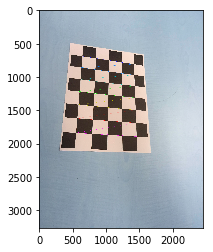

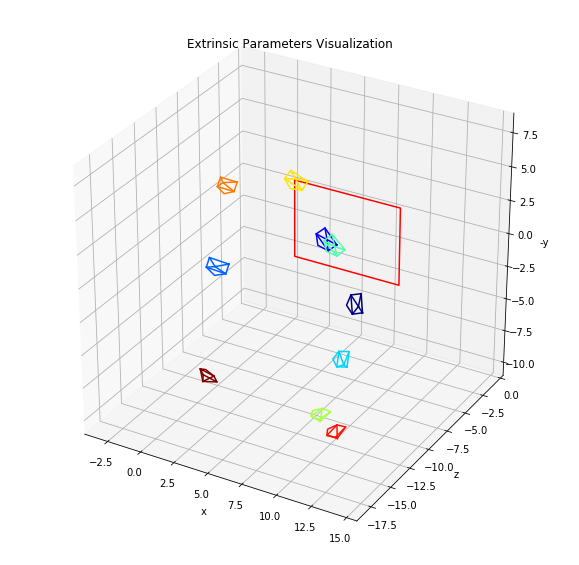

In [8]:
# show the camera extrinsics
print('Show the camera extrinsics')
# plot setting
# You can modify it for better visualization
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
# camera setting
camera_matrix = K
cam_width = 0.064/0.1
cam_height = 0.032/0.1
scale_focal = 1600
# chess board setting
board_width = 8
board_height = 6
square_size = 1
# display
# True -> fix board, moving cameras
# False -> fix camera, moving boards
min_values, max_values = show.draw_camera_boards(ax, camera_matrix, cam_width, cam_height,
                                                scale_focal, extrinsics, board_width,
                                                board_height, square_size, True)
X_min = min_values[0]
X_max = max_values[0]
Y_min = min_values[1]
Y_max = max_values[1]
Z_min = min_values[2]
Z_max = max_values[2]
max_range = np.array([X_max-X_min, Y_max-Y_min, Z_max-Z_min]).max() / 2.0

mid_x = (X_max+X_min) * 0.5
mid_y = (Y_max+Y_min) * 0.5
mid_z = (Z_max+Z_min) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, 0)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_zlabel('-y')
ax.set_title('Extrinsic Parameters Visualization')
plt.show()
plt.close()

min_values, max_values = show.draw_camera_boards(ax, camera_matrix, cam_width, cam_height,
                                                scale_focal, extrinsics, board_width,
                                                board_height, square_size, False)